In [19]:
import pandas as pd
import numpy as np
import librosa
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf

from scene_cls_model import Cnn_9layers_AvgPooling
from dataloader import AudioDataset

In [2]:
# Get correct predictions
eval_df = pd.read_csv('predictions.csv')
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
correct_pred.shape

(2230, 3)

In [3]:
correct_pred.head()

,Filename,Predicted Label,Actual Label
0,/work/aistwal/dataset_tau2019/extracted-files/...,street_pedestrian,street_pedestrian
1,/work/aistwal/dataset_tau2019/extracted-files/...,metro,metro
3,/work/aistwal/dataset_tau2019/extracted-files/...,street_pedestrian,street_pedestrian
4,/work/aistwal/dataset_tau2019/extracted-files/...,street_traffic,street_traffic
7,/work/aistwal/dataset_tau2019/extracted-files/...,airport,airport


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Instantiate and load the model
model = Cnn_9layers_AvgPooling(classes_num=10, activation="logsoftmax")
model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_10_16.pth'
# model_path = '/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_new_10_16.pth'
model_name = model_path.split('/')[-1]
print("model name: ", model_name)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

model name:  tau_2019_conv_10_16.pth


Cnn_9layers_AvgPooling(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [6]:
labels = [
    "airport", "shopping_mall", "metro_station", "street_pedestrian",
    "public_square", "street_traffic", "tram", "bus", "metro", "park"]
lb_to_idx = {lb: idx for idx, lb in enumerate(labels)}
idx_to_lb = {idx: lb for idx, lb in enumerate(labels)}

In [7]:
def preprocessaudios(audio):
    # Load the audio file
    y, sr = librosa.load(audio, sr=32000)
    
    # Convert to log mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=500, n_mels=64)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Normalize the spectrogram
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.mean()) / log_mel_spectrogram.std()
    #print(log_mel_spectrogram.shape) #(64, 641)
    
    # Convert to torch tensor
    log_mel_spectrogram_tensor = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)
    return log_mel_spectrogram_tensor

In [8]:
def predict(model, inputs):
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
    return predicted

In [9]:
# Checking if model works
input = preprocessaudios(correct_pred['Filename'][0]) #torch.Size([1, 64, 641])
preds = predict(model, input)
    
# Print the predicted label
preds = preds.cpu().numpy()
pred_label = idx_to_lb[preds[0]]
print("Label for Predicted scene is ", pred_label, preds[0])

Label for Predicted scene is  street_pedestrian 3


In [10]:
audio_files = correct_pred['Filename'].to_list()
print("Number of audios to be processed: ", len(audio_files))
scene_labels = correct_pred["Actual Label"].map(lb_to_idx).tolist()

Number of audios to be processed:  2230


In [11]:
from torch.utils.data import DataLoader, TensorDataset
# Convert all audios using a custom dataset. then take a sample and use shap deep explainer
dataset = AudioDataset(audio_files, scene_labels)

In [12]:
dataloader = DataLoader(dataset, batch_size=300)

In [13]:
train_features, train_labels = next(iter(dataloader))
train_features.shape

torch.Size([300, 64, 641])

In [14]:
train_features = train_features.to(device)

In [15]:
train_features.shape[0]

300

In [16]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [17]:
import shap
# Create the SHAP explainer
explainer = shap.DeepExplainer(model, train_features)

In [18]:
# Compute SHAP values
shap_values = explainer.shap_values(train_features, check_additivity=False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 750.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 335.69 MiB is free. Process 1225090 has 1.30 GiB memory in use. Including non-PyTorch memory, this process has 45.88 GiB memory in use. Of the allocated memory 45.29 GiB is allocated by PyTorch, and 275.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
shap_values.shape

In [ ]:
class_index = 3

# Example: SHAP values for the first sample and the selected class
class_shap = shap_values[0, :, :, class_index]

plt.figure(figsize=(10, 4))
plt.imshow(class_shap, aspect='auto', origin='lower', cmap='coolwarm')
plt.colorbar()
plt.title(f'SHAP Values for Class {class_index} of First Sample')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Band')
plt.show()

In [79]:
torch.cuda.empty_cache()

In [53]:
type(class_shap), class_shap.shape

(numpy.ndarray, (64, 641))

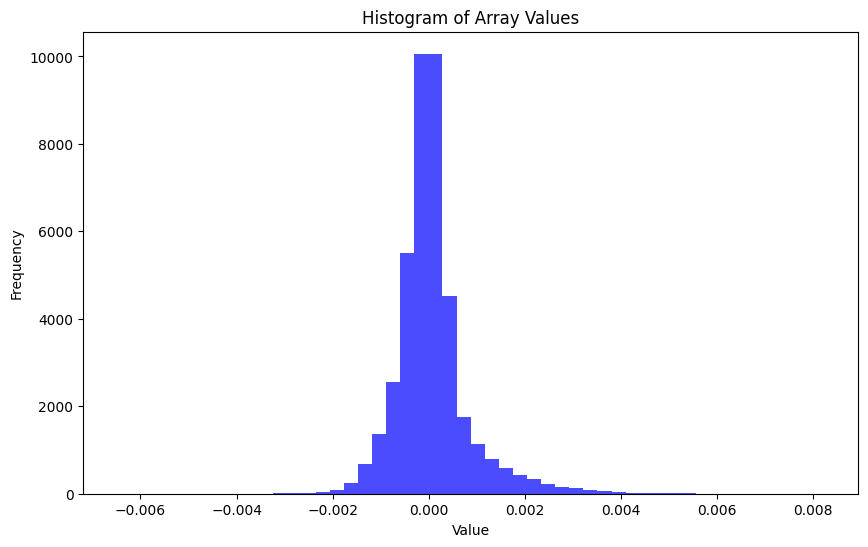

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(class_shap.ravel(), bins=50, color='blue', alpha=0.7)  # Flatten the array to 1D and plot
plt.title('Histogram of Array Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

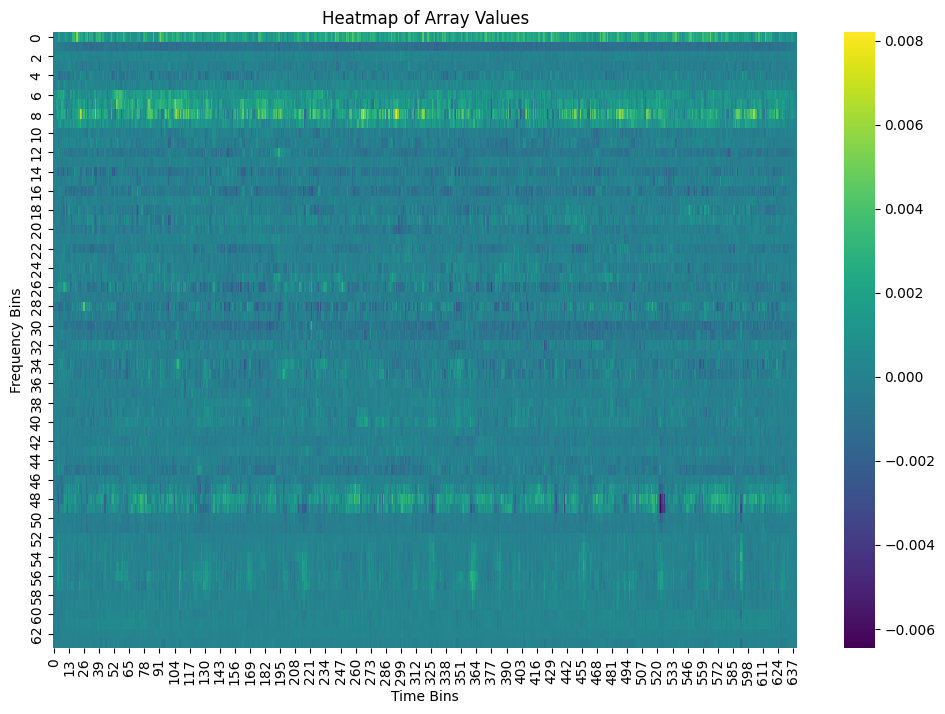

In [58]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(class_shap, cmap='viridis', cbar=True)
plt.title('Heatmap of Array Values')
plt.xlabel('Time Bins')
plt.ylabel('Frequency Bins')
plt.show()

In [27]:
explainer = shap.GradientExplainer(model, train_features)

In [28]:
shap_values = explainer.shap_values(train_features)

In [30]:
shap_values.shape

(100, 64, 641, 10)

In [35]:
# Selecting SHAP values for one class
selected_class_shap_values = shap_values[:, :, :, 3]
selected_class_shap_values.shape

(100, 64, 641)

In [37]:
flattened_features_shap_values.shape

(1, 41024)

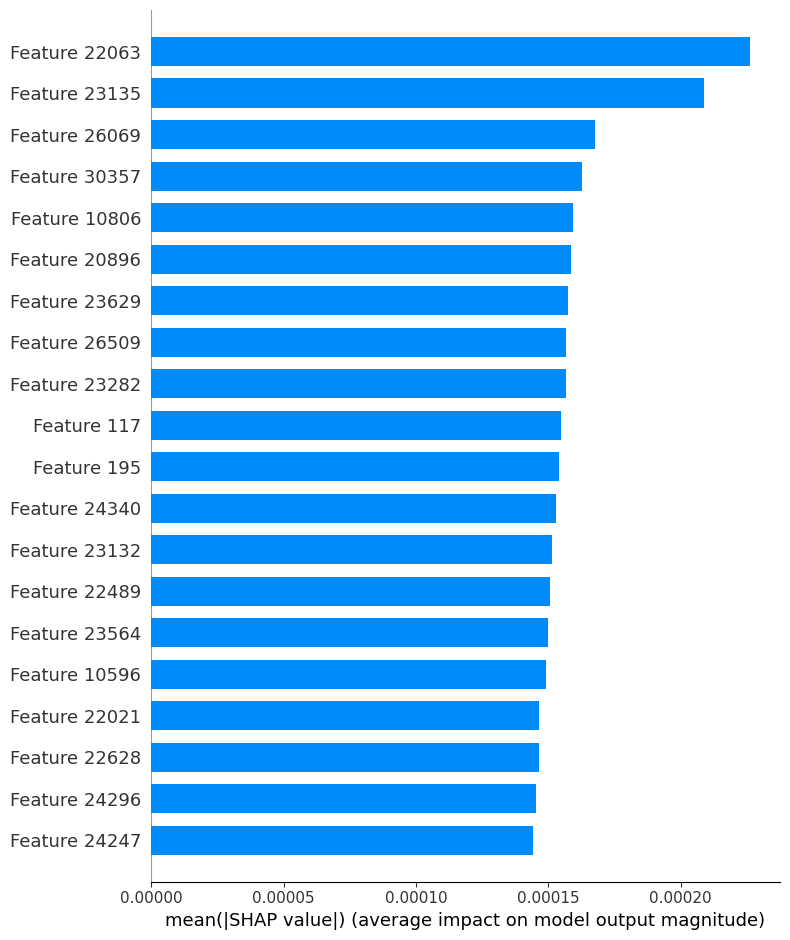

In [40]:
# Averaging over all samples
averaged_shap_values = np.mean(selected_class_shap_values, axis=0)

# Since SHAP summary plots generally expect 2D arrays (samples x features),
# we might flatten the features for simplicity or select a specific set of features.
# Here we flatten all features for simplicity
flattened_features_shap_values = averaged_shap_values.reshape(-1, 641*64)  # Combine all features

# Creating a SHAP summary plot
shap.summary_plot(flattened_features_shap_values, plot_type="bar")